<a href="https://colab.research.google.com/github/hwangtaemin/NLP-with-Disaster-Tweets/blob/main/tweet_BERT_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.5.0
Hub version:  0.12.0


In [9]:
import pandas as pd
import numpy as np

# For cleaning the text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/test.csv')
ids = test.id

print('Total length of the dataset: ', len(train)+len(test))
print('shape of training set: ', train.shape)
print('shape of testing set: ', test.shape)

Total length of the dataset:  10876
shape of training set:  (7613, 5)
shape of testing set:  (3263, 4)


In [12]:
# Detecting null values and records

df_concat = pd.concat([train, test], axis = 0).reset_index(drop = True)
nulls = pd.DataFrame(np.c_[df_concat.isnull().sum(), (df_concat.isnull().sum()/ len(df_concat))*100],
                     columns = ['# of nulls', '% of nulls'],
                     index = df_concat.columns)
nulls

,# of nulls,% of nulls
id,0.0,0.000000
keyword,87.0,0.799926
location,3638.0,33.449798
text,0.0,0.000000
target,3263.0,30.001839


In [13]:
for df in [train, test, df_concat]:

    df.keyword.fillna('no_keyword', inplace = True)
    df.location.fillna('no_location', inplace = True)

In [14]:
df_concat.groupby(['location']).count().text.sort_values(ascending = False)

location
no_location             3638
USA                      141
New York                 109
United States             65
London                    58
                        ... 
Rochelle, GA               1
Robin Hood's County        1
Roanoke VA                 1
Roadside                   1
                           1
Name: text, Length: 4522, dtype: int64

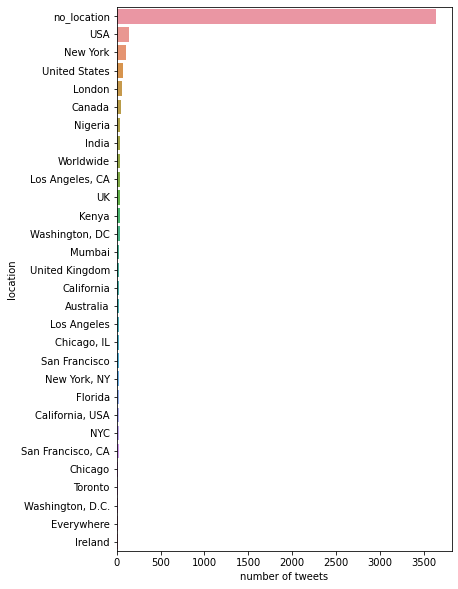

In [15]:
# top 30 locations in the dataset

top_30 = df_concat.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of tweets');

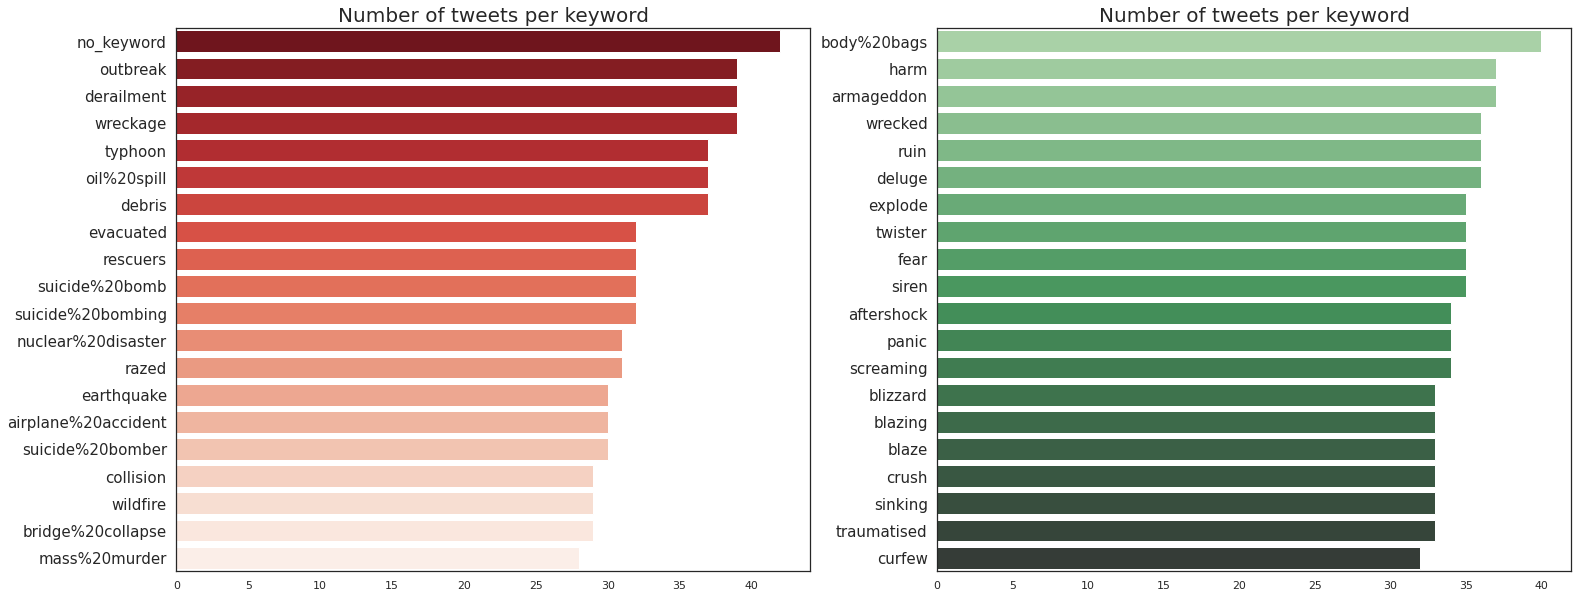

In [16]:
# top 20 keywords in disastrous and non_disastrous tweets
# We'll use training set for this 

count_dis_keywords = train[train.target == 1].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:20]

count_non_dis_keywords =  train[train.target == 0].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:20]

sns.set(style="white")


fig, ax_ = plt.subplots(1, 2, figsize = (25,10));

# left side, the plot for keywords in disastrous tweets

sns.barplot(x = count_dis_keywords.target, # count of each keyword
            y = count_dis_keywords.index, # index of this df is our keywords
            ax = ax_[0],
            palette = 'Reds_r', label = 'dis')
    


# right side, the plot for non_disastrous tweets

sns.barplot(x = count_non_dis_keywords.target, y = count_non_dis_keywords.index, 
            ax = ax_[1], palette = 'Greens_d', label = 'non_dis')


for ax in [ax_[0], ax_[1]]:
    
    ax.set_title('Number of tweets per keyword', fontsize = 20) # setting title
    
    ax.set_ylabel('') 
    ax.set_xlabel('')

    ax.set_yticklabels(labels =ax.get_yticklabels() ,
                       fontsize = 15)

In [17]:
for df in [train, test, df_concat]:

    df.drop(columns = ['location', 'keyword', 'id'], inplace = True)

In [18]:
nlp = spacy.load("en")
sp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

# spacy (362 words)
spacy_st = nlp.Defaults.stop_words
# nltk(179 words)
nltk_st = stopwords.words('english')

def clean(tweet, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)

    # stop words
    # in here I changed the placement of lower for those of you who want to use
    # Cased BERT later on.
    if stop_w == 'nltk':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)

    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    
    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
df_concat['cleaned_text'] = df_concat.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))

In [20]:
cleaned_train = df_concat[:train.shape[0]]
cleaned_test = df_concat[train.shape[0]:]

In [22]:
# Bert Tokenizer for all of them

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [24]:
!pip install sentencepiece
import tokenization

     |████████████████████████████████| 1.2MB 28.9MB/s 


In [25]:
FullTokenizer = tokenization.FullTokenizer

In [26]:
ans = input("Which Bert should I use? \n a. Base uncased \n b. Large uncased \n c. Basic cased \n d. Large cased \n")

if ans is 'a':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    disc = 'Base_uncased'
elif ans is 'b':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2' 
    disc = 'Large_uncased'
elif ans is 'c':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2'
    disc = 'Base_cased'
elif ans is 'd':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2'
    disc = 'Large_cased'

bert_layer = hub.KerasLayer(BERT_MODEL_HUB, trainable=True)
print('Bert layer is ready to use!')



if ans =='a' or ans =='b':
    to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

    tokenizer = FullTokenizer(vocabulary_file, to_lower_case)
    

    
elif ans =='c' or ans =='d':
    
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    
    tokenizer = FullTokenizer(vocabulary_file, do_lower_case=False)


print('Bert Tokenizer is ready!!!')

Which Bert should I use? 
 a. Base uncased 
 b. Large uncased 
 c. Basic cased 
 d. Large cased 
a


INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


Bert layer is ready to use!
Bert Tokenizer is ready!!!


In [27]:
sentence = 'Terrorist will crush the Tower'
print('Tokenized version of {} is : \n {} '.format(sentence, tokenizer.tokenize(sentence)))

Tokenized version of Terrorist will crush the Tower is : 
 ['terrorist', 'will', 'crush', 'the', 'tower'] 


In [28]:
def tokenize_tweets(text_):
    return tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text_) + ['[SEP]'])

df_concat['tokenized_tweets'] = df_concat.cleaned_text.apply(lambda x: tokenize_tweets(x))

cleaned_train.head(2)

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada


In [29]:
# what is the maximum length of our tokenized text?

max_len = len(max(df_concat.tokenized_tweets, key = len))


print('The maximum length of each sequence besed on tokenized tweets is:', max_len)

df_concat['padded_tweets'] = df_concat.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))
df_concat.head(2)

The maximum length of each sequence besed on tokenized tweets is: 53


,text,target,cleaned_text,tokenized_tweets,padded_tweets
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0,Deeds Reason earthquake May ALLAH Forgive us,"[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]","[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada,"[101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 2710, 102]","[101, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 2710, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [30]:
class TweetClassifier:
    
    def __init__(self, tokenizer, bert_layer, max_len, lr = 0.0001,
                 epochs = 15, batch_size = 32,
                 activation = 'sigmoid', optimizer = 'SGD',
                 beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                 metrics = 'accuracy', loss = 'binary_crossentropy'):
        
        self.lr = lr
        self.epochs = epochs
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.bert_layer = bert_layer
        

        self.activation = activation
        self.optimizer = optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon =epsilon
        
        self.metrics = metrics
        self.loss = loss

        
    def encode(self, texts):
        
        all_tokens = []
        masks = []
        segments = []
        
        for text in texts:
            
            tokenized = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + self.tokenizer.tokenize(text) + ['[SEP]'])
            
            len_zeros = self.max_len - len(tokenized)
            
            
            padded = tokenized + [0] * len_zeros
            mask = [1] * len(tokenized) + [0] * len_zeros
            segment = [0] * self.max_len
            
            all_tokens.append(padded)
            masks.append(mask)
            segments.append(segment)
        
        return np.array(all_tokens), np.array(masks), np.array(segments)


    def make_model(self):
        
        # Shaping the inputs to our model
        
        input_ids = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_ids')
        
        input_mask = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_mask')
        
        segment_ids = Input(shape = (self.max_len, ), dtype = tf.int32,  name = 'segment_ids')

        
        pooled_output, sequence_output = bert_layer([input_ids, input_mask, segment_ids] )



        clf_output = sequence_output[:, 0, :]
        
        out = tf.keras.layers.Dense(1, activation = self.activation)(clf_output)
        
        
        model = Model(inputs = [input_ids, input_mask, segment_ids], outputs = out)
        
        # define the optimizer

        if self.optimizer is 'SGD':
            optimizer = SGD(learning_rate = self.lr)

        elif self.optimizer is 'Adam': 
            optimizer = Adam(learning_rate = self.lr, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)

        model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metrics])
        
        print('Model is compiled with {} optimizer'.format(self.optimizer))
        
        return model
    
    
    
    
    def train(self, x):    
        
        checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',
                                     save_best_only=True)
            
        
        model = self.make_model()
        
        X = self.encode(x['cleaned_text'])
        Y = x['target']
        
        model.fit(X, Y, shuffle = True, validation_split = 0.2, 
                  batch_size=self.batch_size, epochs = self.epochs,
                  callbacks=[checkpoint])
                
        print('Model is fit!')
        
            
    def predict(self, x):
        
        X_test_encoded = self.encode(x['cleaned_text'])
        best_model = tf.keras.models.load_model('model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
        y_pred = best_model.predict(X_test_encoded)
        
        
        return y_pred

In [31]:
classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.0001,
                              epochs = 3,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [32]:
classifier.train(cleaned_train)

Model is compiled with SGD optimizer
Epoch 1/3
191/191 [==============================] - 82s 360ms/step - loss: 0.5343 - accuracy: 0.7432 - val_loss: 0.4178 - val_accuracy: 0.8135
Epoch 2/3
191/191 [==============================] - 72s 377ms/step - loss: 0.4194 - accuracy: 0.8184 - val_loss: 0.5331 - val_accuracy: 0.7511
Epoch 3/3
191/191 [==============================] - 71s 374ms/step - loss: 0.3863 - accuracy: 0.8386 - val_loss: 0.4428 - val_accuracy: 0.8096
Model is fit!


In [33]:
y_pred = np.round(classifier.predict(cleaned_test))

In [34]:
# Submission
sample_sub = pd.read_csv('/content/drive/MyDrive/Kaggle/tweet/sample_submission.csv')
ids = sample_sub.id
final_submission = pd.DataFrame(np.c_[ids, y_pred.astype('int')], columns = ['id', 'target'])
final_submission.to_csv('final_submission.csv', index = False)
final_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
